Notebook score is 0.77751

In [1]:
%matplotlib inline

import os, re

import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.preprocessing   import OneHotEncoder
from sklearn.preprocessing   import StandardScaler

from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.ensemble        import AdaBoostClassifier
from sklearn.ensemble        import GradientBoostingClassifier
from sklearn.ensemble        import StackingClassifier

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.ensemble        import VotingClassifier

In [2]:
titanic_df_train = pd.read_csv(os.path.abspath('../datasets/titanic/train.csv'))
titanic_df_test = pd.read_csv(os.path.abspath('../datasets/titanic/test.csv'))

train_len = len(titanic_df_train)
test_len = len(titanic_df_test)

In [3]:
titanic = titanic_df_train.copy().append(titanic_df_test.copy(), ignore_index = True)

The problem is a classification problem, and the target feature is the survivability of a titanic passenger.

Since there is already a test set, we will not create another validation set. Instead, we will use cross-validation for that mater.

# Exploratory data analysis

In [4]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,1309.000000,891.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,655.000000,0.383838,2.294882,29.881138,0.498854,0.385027,33.295479
std,378.020061,0.486592,0.837836,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,328.000000,0.000000,2.000000,21.000000,0.000000,0.000000,7.895800
50%,655.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,982.000000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,1309.000000,1.000000,3.000000,80.000000,8.000000,9.000000,512.329200


<AxesSubplot:>

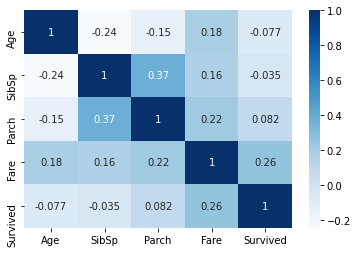

In [5]:
sns.heatmap(titanic[['Age', 'SibSp', 'Parch', 'Fare', 'Survived']].corr(), annot = True, cmap = 'Blues')

Fare is the most correlated feature with respect to survivability.

Parch and SibSp are also highly correlated.

## Categorical

### Sex

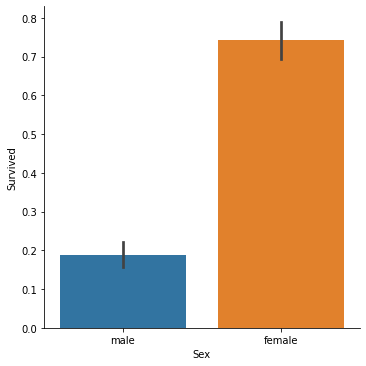

In [6]:
sns.catplot(kind = 'bar', data = titanic, x = 'Sex', y = 'Survived')

Sex is an important feature for predicting survivability it seems.

Women have greater chance of survival than men.

### Pclass

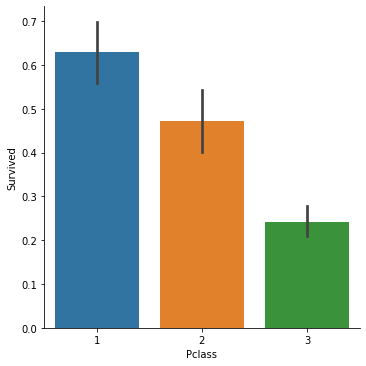

In [7]:
sns.catplot(kind = 'bar', data = titanic, x = 'Pclass', y = 'Survived')

3rd class has much lower survivability.

And since the 3rd class is the majority, then those who did not survive are mainly from 3rd class.

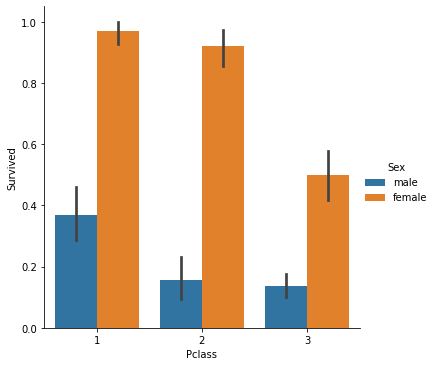

In [8]:
sns.catplot(kind = 'bar', data = titanic, x = 'Pclass', y = 'Survived', hue = 'Sex')

Survivability rate keep the same tendency in regard to both sexes.

### Embarked

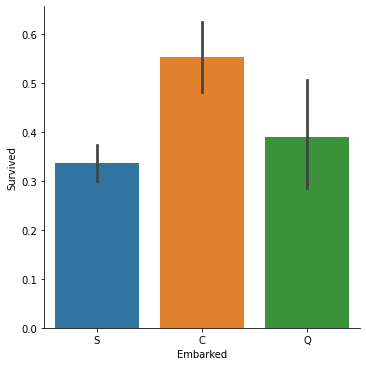

In [9]:
sns.catplot(kind = 'bar', data = titanic, x = 'Embarked', y = 'Survived')

Passengers embarked from port S (Southampton) have the lowest survival rate. 

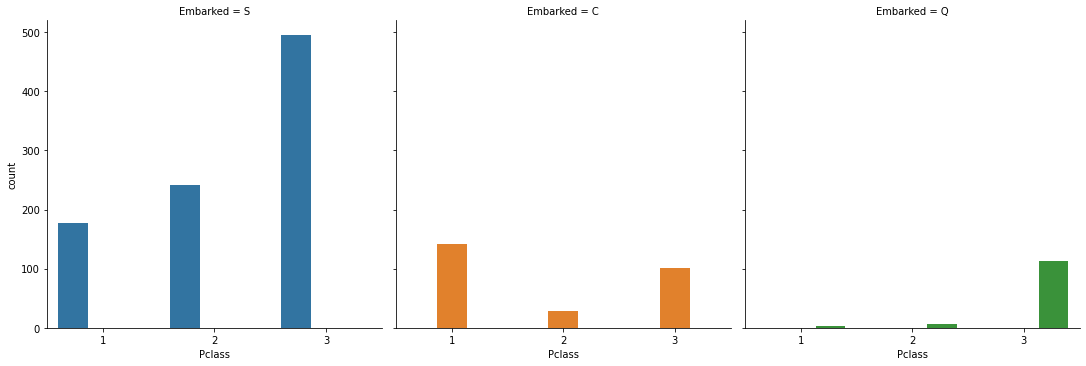

In [10]:
sns.catplot(kind = 'count', data = titanic, x = 'Pclass', hue = 'Embarked', col = 'Embarked')

It appears that port C (Cherbourg) has the highest survival rate because it has a relatively higher 1st class passengers ratio.

## Numerical

### SibSP

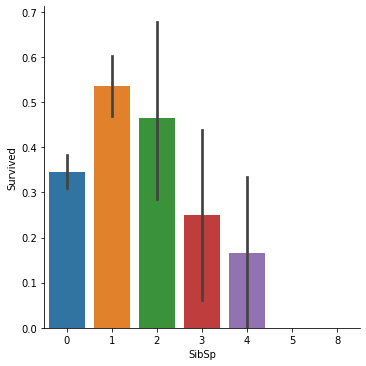

In [11]:
sns.catplot(kind = 'bar', data = titanic, x = 'SibSp', y = 'Survived')

### Parch

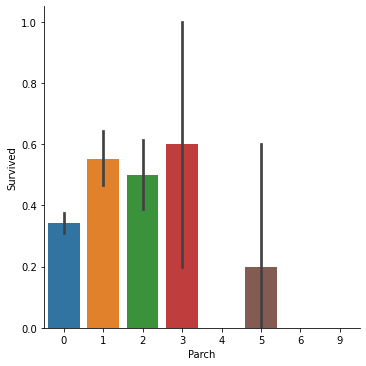

In [12]:
sns.catplot(kind = 'bar', data = titanic, x = 'Parch', y = 'Survived')

### Age

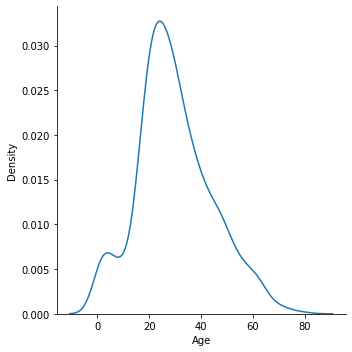

In [13]:
sns.displot(kind = 'kde', data = titanic, x = 'Age')

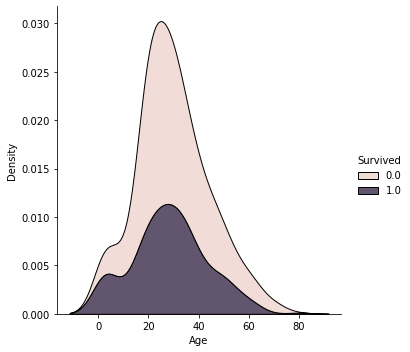

In [14]:
sns.displot(kind = 'kde', data = titanic, x = 'Age', hue = 'Survived', multiple = 'stack')

### Fare

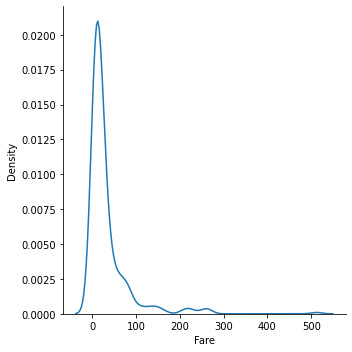

In [15]:
sns.displot(kind = 'kde', data = titanic, x = 'Fare')

In [16]:
titanic["Fare"].skew()

4.367709134122922

Fare distribution is skewed, we will use log transformation to reduce its skewness.

In [17]:
titanic["Fare"] = titanic["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

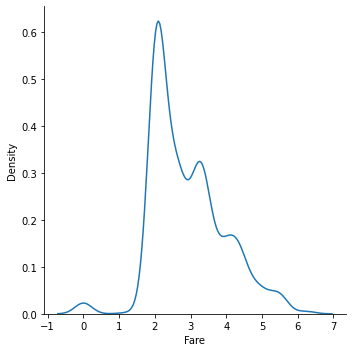

In [18]:
sns.displot(kind = 'kde', data = titanic, x = 'Fare')

In [19]:
titanic["Fare"].skew()

0.5516464212491966

## Missing values

In [20]:
df_prepared = pd.DataFrame()
cat_1hot_encoder = OneHotEncoder()
std_scaler = StandardScaler()

In [21]:
def one_hot_encode(df, prefix):
    cat_1hot_encoder.fit(df)
    return [prefix + '_' + str(cat).lower() for cat in cat_1hot_encoder.categories_[0]]

In [22]:
df_prepared = pd.concat([df_prepared, pd.DataFrame(std_scaler.fit_transform(titanic[['Fare']]), columns = ['fare'])], axis = 1)

In [23]:
titanic.isna().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          2
dtype: int64

### Age

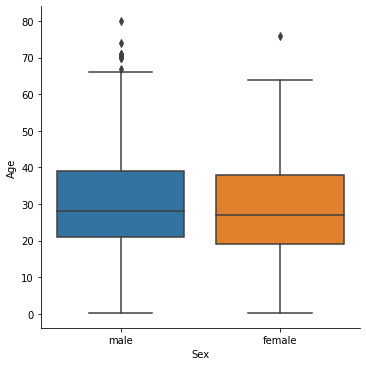

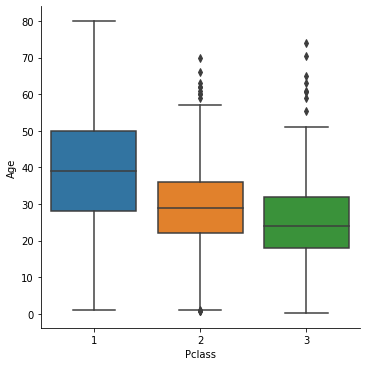

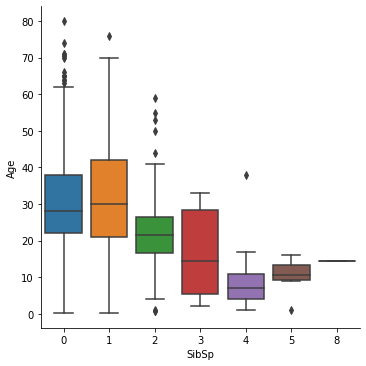

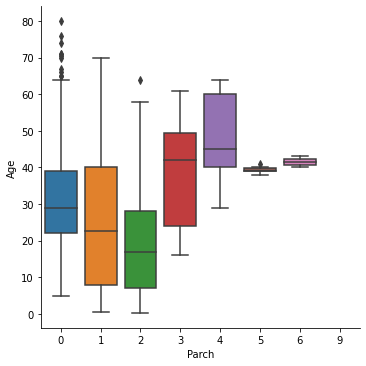

In [24]:
sns.catplot(kind = 'box', data = titanic, x = 'Sex', y = 'Age')
sns.catplot(kind = 'box', data = titanic, x = 'Pclass', y = 'Age')
sns.catplot(kind = 'box', data = titanic, x = 'SibSp', y = 'Age')
sns.catplot(kind = 'box', data = titanic, x = 'Parch', y = 'Age')

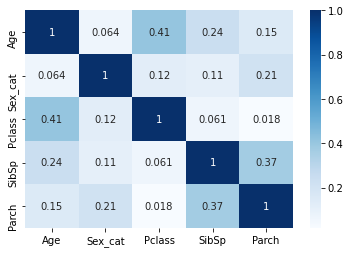

In [25]:
titanic['Sex_cat'] = titanic['Sex'].map({'male': 1, 'female': 0})
sns.heatmap(titanic[['Age', 'Sex_cat', 'Pclass', 'SibSp', 'Parch']].corr().abs(), annot = True, cmap = 'Blues')
titanic.drop('Sex_cat', axis = 1, inplace = True)

Passenger Class and SibSp are the most important features for predicting survival, so we will use them to subdivide the dataset and fill the missing age values for each category.

In [26]:
titanic['Age'] = titanic.groupby(['Pclass', 'SibSp'])['Age'].apply(lambda x: x.fillna(x.median()))

In [27]:
df_prepared = pd.concat([df_prepared, pd.DataFrame(std_scaler.fit_transform(titanic[['Age']]), columns = ['age'])], axis = 1)

### Embarked

Embarked feature is filled with the mode value.

In [28]:
titanic['Embarked'].fillna(titanic['Embarked'].mode()[0], inplace = True)

In [29]:
columns = one_hot_encode(titanic[['Embarked']], 'embarked')
df_prepared = pd.concat([df_prepared, pd.DataFrame(cat_1hot_encoder.transform(titanic[['Embarked']]).toarray(), columns = columns)], axis = 1)

### Cabin

Cabin first letter indicate the cabin location on the ship, and thus is important for deducing survival rate. 

In [30]:
titanic['Cabin'] = titanic['Cabin'].apply(lambda x: x[0].upper() if not pd.isna(x) else 'X')

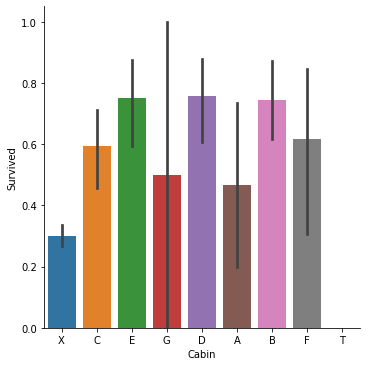

In [31]:
sns.catplot(kind = 'bar', data = titanic, x = 'Cabin', y = 'Survived')

In [32]:
columns = one_hot_encode(titanic[['Cabin']], 'cabin')
df_prepared = pd.concat([df_prepared, pd.DataFrame(cat_1hot_encoder.transform(titanic[['Cabin']]).toarray(), columns = columns)], axis = 1)

## Features Engineering

### Ticket

Ticket number may has less informations to convey, but the ticket prefix indicate where the ticket was booked.

In [33]:
titanic['Ticket'] = titanic['Ticket'].apply(lambda x: x.replace('.', '').replace('/', '').split(' ')[0] if len(x.split()) >= 2 else 'X')

In [34]:
columns = one_hot_encode(titanic[['Ticket']], 'ticket')
df_prepared = pd.concat([df_prepared, pd.DataFrame(cat_1hot_encoder.transform(titanic[['Ticket']]).toarray(), columns = columns)], axis = 1)

### Title

Honorifics attached to passengers names can give insight on their importance.

In [35]:
titanic['Title'] = titanic['Name'].apply(lambda x: re.search(", (.+?)\.", x).group(1).strip() if re.search(", (.+?)\.", x) != None else 'X')

In [36]:
titanic['Title'].value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Major             2
Mlle              2
Don               1
Mme               1
Sir               1
Jonkheer          1
Capt              1
Dona              1
Lady              1
the Countess      1
Name: Title, dtype: int64

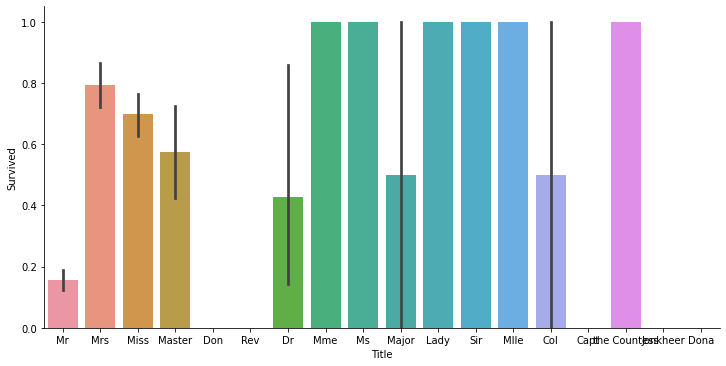

In [37]:
sns.catplot(kind = 'bar', data = titanic, x = 'Title', y = 'Survived', aspect = 2)

There is a group of titles rarely used and that have pretty much the same meaning as the classical english equivalents. So they will be grouped in a special category.

In [38]:
titanic['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Capt', 'Jonkheer', 'Lady', 'Don', 'Sir', 'Dona', 'the Countess'], 'Rare', inplace = True)
titanic['Title'].replace(['Miss', 'Mrs', 'Ms', 'Mlle', 'Mme'], 'Mrs', inplace = True)

In [39]:
titanic['Title'].value_counts()

Mr        757
Mrs       462
Master     61
Rare       29
Name: Title, dtype: int64

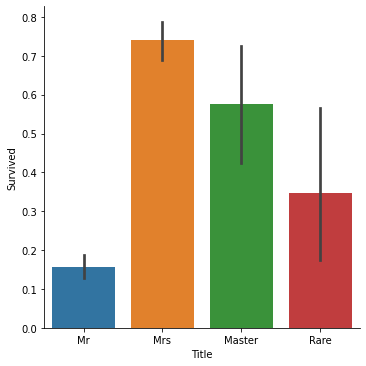

In [40]:
sns.catplot(kind = 'bar', data = titanic, x = 'Title', y = 'Survived')

In [41]:
columns = one_hot_encode(titanic[['Title']], 'title')
df_prepared = pd.concat([df_prepared, pd.DataFrame(cat_1hot_encoder.transform(titanic[['Title']]).toarray(), columns = columns)], axis = 1)

### Family size

We observed earlier that Parch and SibSp are highly correlated. So we will combine those two attributs in a new one expressing family size.

In [42]:
titanic["Fsize"] = titanic["Parch"] + titanic["SibSp"] + 1

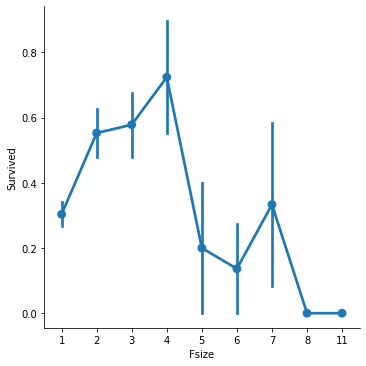

In [43]:
sns.catplot(kind = 'point', data = titanic, x = 'Fsize', y = 'Survived')

In [44]:
titanic['Single'] = titanic['Fsize'].map(lambda s: 1 if s == 1 else 0)
titanic['SmallF'] = titanic['Fsize'].map(lambda s: 1 if  s == 2  else 0)
titanic['MedF'] = titanic['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
titanic['LargeF'] = titanic['Fsize'].map(lambda s: 1 if s >= 5 else 0)

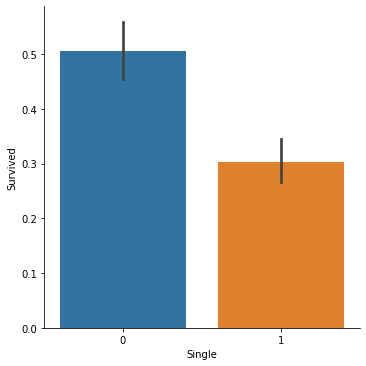

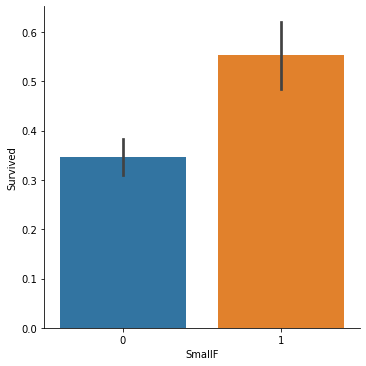

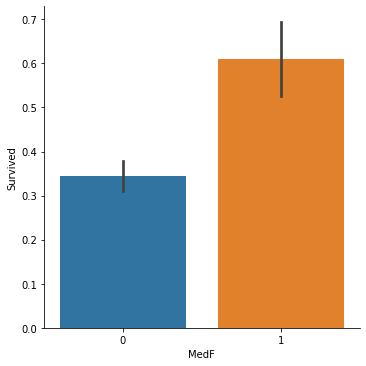

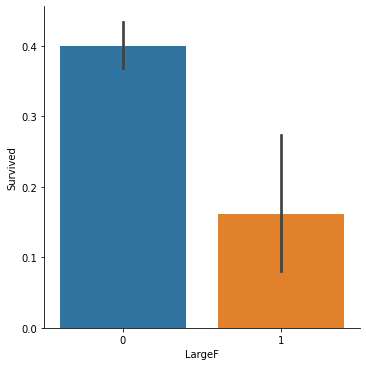

In [45]:
sns.catplot(kind = 'bar', data = titanic, x = 'Single', y = 'Survived')
sns.catplot(kind = 'bar', data = titanic, x = 'SmallF', y = 'Survived')
sns.catplot(kind = 'bar', data = titanic, x = 'MedF', y = 'Survived')
sns.catplot(kind = 'bar', data = titanic, x = 'LargeF', y = 'Survived')

In [46]:
df_prepared = pd.concat([df_prepared, titanic[['Single', 'SmallF', 'MedF', 'LargeF']]], axis = 1)

In [47]:
df_prepared.columns

Index(['fare', 'age', 'embarked_c', 'embarked_q', 'embarked_s', 'cabin_a',
       'cabin_b', 'cabin_c', 'cabin_d', 'cabin_e', 'cabin_f', 'cabin_g',
       'cabin_t', 'cabin_x', 'ticket_a', 'ticket_a4', 'ticket_a5',
       'ticket_aq3', 'ticket_aq4', 'ticket_as', 'ticket_c', 'ticket_ca',
       'ticket_casoton', 'ticket_fc', 'ticket_fcc', 'ticket_fa', 'ticket_lp',
       'ticket_pc', 'ticket_pp', 'ticket_ppp', 'ticket_sc', 'ticket_sca3',
       'ticket_sca4', 'ticket_scah', 'ticket_scow', 'ticket_scparis',
       'ticket_scparis', 'ticket_soc', 'ticket_sop', 'ticket_sopp',
       'ticket_sotono2', 'ticket_sotonoq', 'ticket_sp', 'ticket_stono',
       'ticket_stono2', 'ticket_stonoq', 'ticket_swpp', 'ticket_wc',
       'ticket_wep', 'ticket_x', 'title_master', 'title_mr', 'title_mrs',
       'title_rare', 'Single', 'SmallF', 'MedF', 'LargeF'],
      dtype='object')

In [48]:
titanic.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Title', 'Fsize',
       'Single', 'SmallF', 'MedF', 'LargeF'],
      dtype='object')

In [49]:
df_prepared = pd.concat([df_prepared, titanic[['Pclass']]], axis = 1)
df_prepared = pd.concat([df_prepared, titanic[['SibSp']]], axis = 1)
df_prepared = pd.concat([df_prepared, titanic[['Parch']]], axis = 1)

columns = one_hot_encode(titanic[['Sex']], 'sex')
df_prepared = pd.concat([df_prepared, pd.DataFrame(cat_1hot_encoder.transform(titanic[['Sex']]).toarray(), columns = columns)], axis = 1)

## Training set preparation

In [50]:
df_prepared_train = df_prepared[:train_len]
df_prepared_test = df_prepared[train_len:]

In [51]:
df_labels = titanic[:train_len]["Survived"].copy()

# Models selection

In [52]:
random_state = 42

classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier(n_neighbors = 10))
classifiers.append(AdaBoostClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))

cv_results = []
for cls_ in classifiers:
    cv_results.append(cross_val_score(cls_, df_prepared_train, df_labels, cv = 10, scoring = 'accuracy'))
cv_results = pd.DataFrame(cv_results, index = ['LogisticRegression', 'SVC', 'DecisionTreeClassifier',
                                    'RandomForestClassifier', 'ExtraTreesClassifier', 'KNeighborsClassifier', 
                                    'AdaBoostClassifier', 'GradientBoostingClassifier']).transpose()

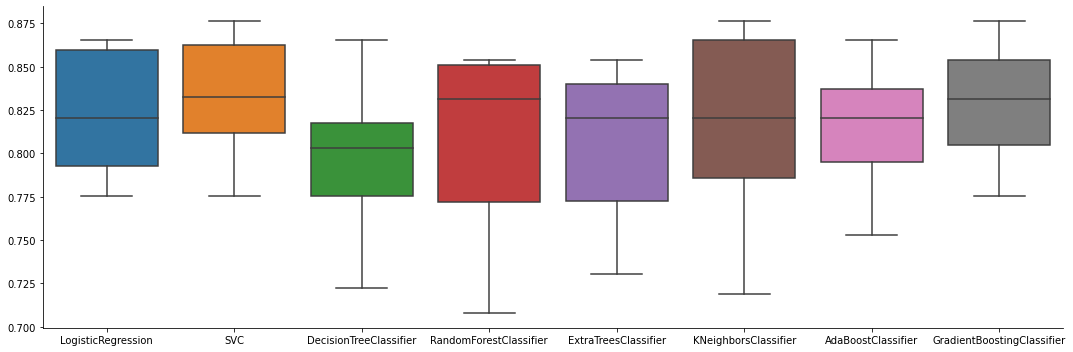

In [53]:
sns.catplot(kind = 'box', data = cv_results, aspect = 3)

In [54]:
cv_results.mean().sort_values(ascending = False)

SVC                           0.832772
GradientBoostingClassifier    0.828315
LogisticRegression            0.823808
KNeighborsClassifier          0.818227
AdaBoostClassifier            0.815980
RandomForestClassifier        0.810387
ExtraTreesClassifier          0.805893
DecisionTreeClassifier        0.794694
dtype: float64

In [55]:
cv_results.std().sort_values(ascending = True)

LogisticRegression            0.034660
AdaBoostClassifier            0.034903
SVC                           0.035707
GradientBoostingClassifier    0.035739
DecisionTreeClassifier        0.040067
ExtraTreesClassifier          0.042350
KNeighborsClassifier          0.052429
RandomForestClassifier        0.052496
dtype: float64

I will use Logistic Regression, SVC, AdaBoost Classifier and GradientBoostingClassifier for the training of an ensemble learning algorithm.

Those algorithms are the best trad off between accuracy and standard deviation.

## Hyperparameter

### Logistic Regression

In [56]:
log_reg = LogisticRegression(random_state = random_state)
log_reg_param_grid = {
    'C': [50.0, 10.0, 1.0, 0.1, 0.01],
    'max_iter': [500]
}

log_reg_grid_search = GridSearchCV(log_reg, param_grid = log_reg_param_grid, cv = 10, scoring = 'accuracy', verbose = 1)

log_reg_grid_search.fit(df_prepared_train, df_labels)

Fitting 10 folds for each of 5 candidates, totalling 50 fits


GridSearchCV(cv=10, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [50.0, 10.0, 1.0, 0.1, 0.01], 'max_iter': [500]},
             scoring='accuracy', verbose=1)

In [57]:
log_reg_grid_search.best_score_

0.8238077403245943

### SVC

In [58]:
svc_cls = SVC(random_state = random_state)
svc_cls_param_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [50.0, 10.0, 1.0, 0.1, 0.01],
    'gamma': ['scale']
}

svc_cls_grid_search = GridSearchCV(svc_cls, param_grid = svc_cls_param_grid, cv = 10, scoring = 'accuracy', verbose = 1)

svc_cls_grid_search.fit(df_prepared_train, df_labels)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10, estimator=SVC(random_state=42),
             param_grid={'C': [50.0, 10.0, 1.0, 0.1, 0.01], 'gamma': ['scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             scoring='accuracy', verbose=1)

In [59]:
svc_cls_grid_search.best_score_

0.8327715355805243

### AdaBoost Classifier

In [60]:
adb_cls = AdaBoostClassifier(random_state = random_state)
adb_cls_param_grid = {
    'learning_rate': [10.0, 1.0, 0.1],
    'n_estimators': [30, 50, 100, 200]
}

adb_cls_grid_search = GridSearchCV(adb_cls, param_grid = adb_cls_param_grid, cv = 10, scoring = 'accuracy', verbose = 1)

adb_cls_grid_search.fit(df_prepared_train, df_labels)

Fitting 10 folds for each of 12 candidates, totalling 120 fits


GridSearchCV(cv=10, estimator=AdaBoostClassifier(random_state=42),
             param_grid={'learning_rate': [10.0, 1.0, 0.1],
                         'n_estimators': [30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [61]:
adb_cls_grid_search.best_score_

0.826067415730337

### Gradient Boosting Classifier

In [62]:
grb_cls = GradientBoostingClassifier(random_state = random_state)
grb_cls_param_grid = {
    'learning_rate': [10.0, 1.0, 0.1, 0.01],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5]
}

grb_cls_grid_search = GridSearchCV(grb_cls, param_grid = grb_cls_param_grid, cv = 10, scoring = 'accuracy', verbose = 1)

grb_cls_grid_search.fit(df_prepared_train, df_labels)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'learning_rate': [10.0, 1.0, 0.1, 0.01],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [63]:
grb_cls_grid_search.best_score_

0.835043695380774

### Random Forest Classifier

In [64]:
forest_cls = RandomForestClassifier(random_state = random_state, n_jobs = 4)
forest_cls_param_grid = {
    'n_estimators': [300,  100],
    'max_features': ['sqrt', 'log2', 10],
    'bootstrap': [False, True],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 10]
}

forest_cls_grid_search = GridSearchCV(forest_cls, param_grid = forest_cls_param_grid, cv = 10, scoring = 'accuracy', verbose = 1)

forest_cls_grid_search.fit(df_prepared_train, df_labels)

Fitting 10 folds for each of 48 candidates, totalling 480 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(n_jobs=4, random_state=42),
             param_grid={'bootstrap': [False, True],
                         'max_features': ['sqrt', 'log2', 10],
                         'min_samples_leaf': [1, 10],
                         'min_samples_split': [2, 10],
                         'n_estimators': [300, 100]},
             scoring='accuracy', verbose=1)

In [65]:
forest_cls_grid_search.best_score_

0.8361548064918851

In [66]:
best_classifiers = [('LogisticRegression', log_reg_grid_search.best_estimator_),
                    ('SVC', svc_cls_grid_search.best_estimator_),
                    ('AdaBoostClassifier', adb_cls_grid_search.best_estimator_),
                    ('GradientBoostingClassifier', grb_cls_grid_search.best_estimator_),
                    ('RandomForstClassifier', forest_cls_grid_search.best_estimator_)
                   ]

<AxesSubplot:>

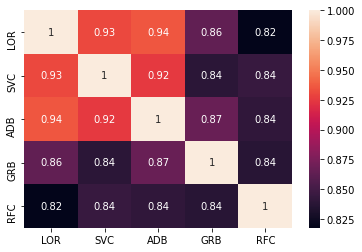

In [67]:
test_prediction_log_reg = pd.Series(best_classifiers[0][1].predict(df_prepared_test), name = 'LOR')
test_prediction_svc_cls = pd.Series(best_classifiers[1][1].predict(df_prepared_test), name = 'SVC')
test_prediction_adb_cls = pd.Series(best_classifiers[2][1].predict(df_prepared_test), name = 'ADB')
test_prediction_grb_cls = pd.Series(best_classifiers[3][1].predict(df_prepared_test), name = 'GRB')
test_prediction_forest_cls = pd.Series(best_classifiers[4][1].predict(df_prepared_test), name = 'RFC')

ensemble_results = pd.concat([test_prediction_log_reg, test_prediction_svc_cls, 
                              test_prediction_adb_cls, test_prediction_grb_cls, 
                              test_prediction_forest_cls], axis = 1)

sns.heatmap(ensemble_results.corr(), annot = True)

In [68]:
vot_cls = VotingClassifier(estimators = best_classifiers)
vot_score = cross_val_score(vot_cls, df_prepared_train, df_labels, cv = 10, scoring = 'accuracy')
vot_score.mean(), vot_score.std()

(0.8406367041198501, 0.03647072857566337)

In [69]:
stack_cls = StackingClassifier(estimators = best_classifiers, stack_method = 'predict', n_jobs = 4)
stack_score = cross_val_score(stack_cls, df_prepared_train, df_labels, cv = 10, scoring = 'accuracy')
stack_score.mean(), stack_score.std()

(0.840649188514357, 0.03640665211465838)

In [70]:
stack_cls.fit(df_prepared_train, df_labels)
final_predictor = stack_cls

# Submission

In [71]:
predictions = final_predictor.predict(df_prepared_test)

In [72]:
submission = pd.DataFrame()
submission["PassengerId"] = titanic_df_test["PassengerId"].copy()
submission["Survived"] = pd.Series(data = predictions.astype(int))

In [73]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


In [74]:
submission.to_csv(os.path.abspath('../datasets/titanic/submission.csv'), index = False)